***Квадратичная функция***

                      Методы второго порядка
Дано:
Целевая функция:        f(x, y) =  6*x**2 - 4*x*y + 8.94427190999916*x + 3*y**2 + 17.8885438199983*y + 22
Начальное приближение:  X =  [4 1]
Точность вычисления:    Eps =  0.01

**********************************************************************************************************************************************************************
Методы	        Классический метод Ньютона	      Метод Ньютона с наискорейшим	    Метод Марквардта
Xmin  		 [-2.23606798 -4.47213595] 		 [-2.23606798 -4.47213595] 	 [-2.23596634 -4.47193283]
f(Xmin)			 -28.0 					 -28.0 			 -27.9999998968227
i			 1 					 1 					 10
n			 0 					 44 					 11
g			 2 					 2 					 11
h			 1 					 1 					 10
**********************************************************************************************************************************************************************


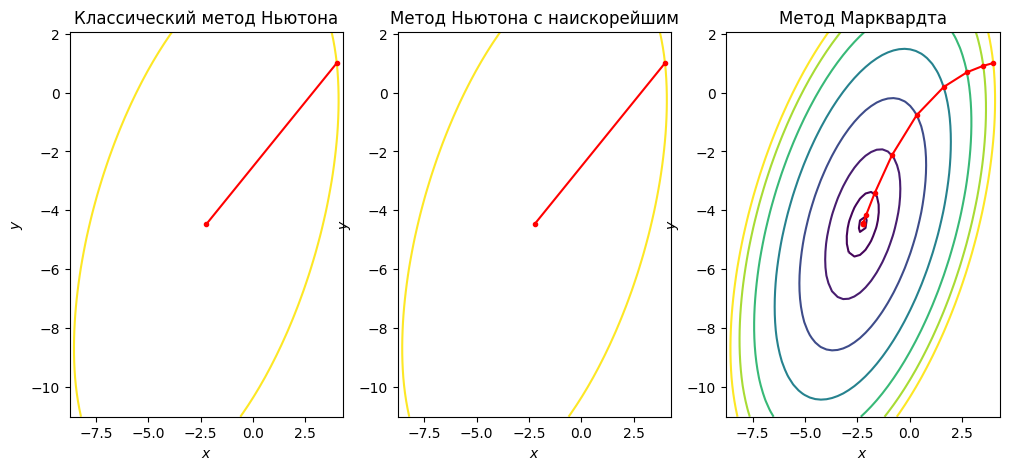

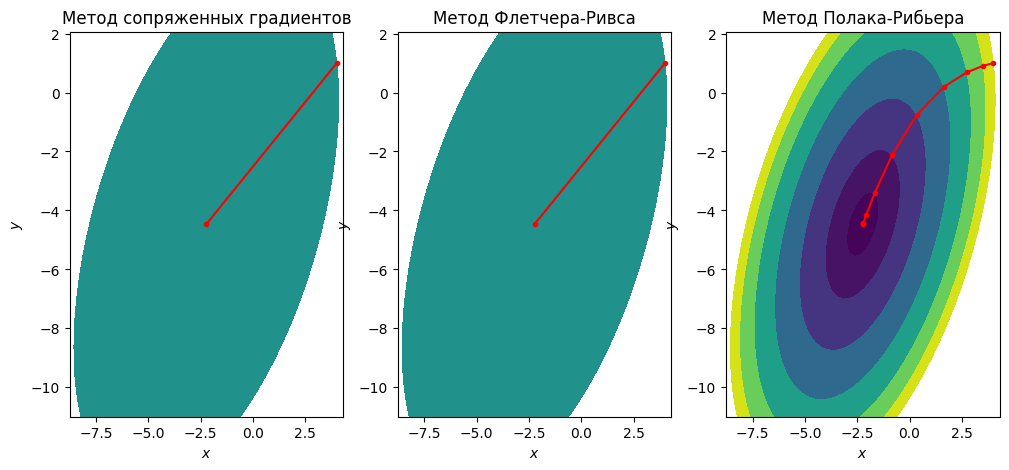

In [1]:
from ast import While
from cmath import sqrt
from sympy.tensor.array import derive_by_array
from scipy import optimize
from operator import mod
import numpy as np
import sympy as sp
import math

import matplotlib.pyplot as plt



# Параметры методов:
eps = 0.01
X0 = np.array([4, 1])

f2 = lambda x, y: 10*x**2-4*x*y+7*y**2-4*5**(1/2)*(5*x-y)-16
f3 = lambda x, y: 6*x**2-4*x*y+3*y**2+4*5**(1/2)*(x+2*y)+22 
f4 = lambda x, y: x**2+y**2-1.2*x*y
f = f3

f5 = lambda x,y: 5 * (x**2 - y)**2 + (x - 1)**2


# Вычисление градиента:
x_sym, y_sym = sp.Symbol('x'), sp.Symbol('y')
Grad_f = derive_by_array(f(x_sym, y_sym), [x_sym, y_sym])
Grad_f = sp.lambdify((x_sym, y_sym), Grad_f, 'numpy')

# Вычисление гессиана
Hessian_f = derive_by_array(derive_by_array(f(x_sym, y_sym), [x_sym, y_sym]), [x_sym, y_sym])
Hessian_f = sp.lambdify((x_sym, y_sym), Hessian_f, 'numpy')




#Проверка положительной определенности
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


#Метод золотого сечения
def golden_ratio(phi, n, b = 20, a = 0, e = eps):
    tau = (math.sqrt(5) + 1) / 2
    Ak, Bk = a, b
    lk = Bk - Ak
    Xk1 = Ak + ((Bk - Ak) - (Bk - Ak) / tau)
    Xk2 = Ak + (Bk - Ak) / tau
    y1, y2 = phi(Xk1), phi(Xk2)
    n += 2
    while lk >= e/100:
        if y1 >= y2:
            Ak = Xk1
            Xk1 = Xk2
            Xk2 = Ak + Bk - Xk1
            y1 = y2
            y2 = phi(Xk2)
            n +=1
        else:
            Bk = Xk2
            Xk2 = Xk1
            Xk1 = Ak + Bk - Xk2
            y2 = y1
            y1 = phi(Xk1)
            n +=1
        lk = Bk - Ak
    return (Ak + Bk) / 2, n


#Классический метод Ньютона
def newtown():
    w = lambda X: -np.array(Grad_f(X[0], X[1]))
    fun = lambda X: f(X[0], X[1])
    X = X0
    X_p, Y_p = np.empty(0), np.empty(0)
    X_p = np.append(X_p, X[0])
    Y_p = np.append(Y_p, X[1])
    wk = w(X)
    g = 1
    i = n = 0 
    H = Hessian_f(X[0],X[1])
    h = 1
    while np.linalg.norm(wk) > eps:
        eta = 0
        while is_pos_def(H) == False:
            eta += 1
            H = eta * np.eye(2) + H
        
        #находим решение СЛАУ рк
        p = np.linalg.solve(H, wk) 
        #наша следующая точка
        Xk = X + p
        X = Xk
        X_p = np.append(X_p, X[0])
        Y_p = np.append(Y_p, X[1])
        wk = w(Xk)
        g += 1 
        H = Hessian_f(X[0],X[1])
        i += 1

    return X, X_p, Y_p, i, n, g, h

    
#Модификация метода Ньютона с наискорейшим
def newton_with_fastest():
    w = lambda X: -np.array(Grad_f(X[0], X[1]))
    fun = lambda X: f(X[0], X[1])

    X_p, Y_p = np.empty(0), np.empty(0)
    X = X0
    X_p = np.append(X_p, X[0])
    Y_p = np.append(Y_p, X[1])
    i = n = h = 0
    g = 1
    while np.linalg.norm(w(X)) > eps:

        H = Hessian_f(X[0],X[1])
        h += 1

        #проверка положительной определенности
        eta = 0
        while is_pos_def(H) == False:
            eta += 0.1
            H = eta * np.eye(2) + H

        #находим решение СЛАУ р
        p = np.linalg.solve(H, w(X))
        
        #минимизируем функцию
        phi = lambda kappa: fun(X + kappa * p)
        kappa, arg, k = optimize.golden(phi, full_output = True)
        #kappa, n = golden_ratio(phi, n)
        n += k

        X = X + kappa * p
        X_p = np.append(X_p, X[0])
        Y_p = np.append(Y_p, X[1])
        i += 1
        g += 1
    return X, X_p, Y_p, i, n, g, h



#Модификация метода Ньютона - метод Марквардта
def newton_markvardt():
    w = lambda X: -np.array(Grad_f(X[0], X[1]))
    fun = lambda X: f(X[0], X[1])

    a0 = 100
    b = 0.5
    X = X0
    wk = w(X)
    g = 1
    X_p, Y_p = np.empty(0), np.empty(0)
    X_p = np.append(X_p, X[0])
    Y_p = np.append(Y_p, X[1])
    n = 1
    i = h = 0
    while 1:
        a = a0
        H = Hessian_f(X[0], X[1])
        h += 1
        while 2:
            #вычисляем направление
            s = np.linalg.solve(H + a * np.eye(2), wk)
            #находим точку
            Xk = X + s
            n += 1
            if fun(X) > fun(X + s):
                break
            a /= b
        

        a0 *= b
        i += 1
        X = Xk
        X_p = np.append(X_p, X[0])
        Y_p = np.append(Y_p, X[1])
        wk = w(X)
        g += 1
        if np.linalg.norm(wk) < eps:
            break
    return X, X_p, Y_p, i, n, g ,h



#Не очень картинки
def DrawSurfContourAndWk(X2, X3, X4, X2_p, Y2_p, X3_p, Y3_p, X4_p, Y4_p):
    fig = plt.figure(figsize =(12,5))
    #fig.canvas.manager.full_screen_toggle()

    axes1 = fig.add_subplot(1, 3, 1)
    axes2 = fig.add_subplot(1, 3, 2)
    axes3 = fig.add_subplot(1, 3, 3)
    
    fig.canvas.manager.set_window_title('Методы сопряженного градиента')


    delta = max(abs(X2[0] - X0[0]), abs(X2[1] - X0[1])) + 0.3
    X, Y = np.meshgrid(np.linspace(X2[0] - delta, X2[0] + delta, 50),
    np.linspace(X2[1] - delta, X2[1] + delta, 50))
    # X, Y = np.meshgrid(X_p1, Y_p1)
    Z = f(X, Y)
    axes1.contourf(X, Y, Z, levels = Val(X2_p, Y2_p))
    axes1.plot(X2_p, Y2_p, marker='o', markersize=3, color='red')
    axes1.set_xlabel('$x$')
    axes1.set_ylabel('$y$')
    axes1.set_title('Метод сопряженных градиентов')

   
    delta = max(abs(X3[0] - X0[0]), abs(X3[1] - X0[1])) + 0.3
    X, Y = np.meshgrid(np.linspace(X3[0] - delta, X3[0] + delta, 50),
    np.linspace(X3[1] - delta, X3[1] + delta, 50))
    # X, Y = np.meshgrid(X_p1, Y_p1)
    Z = f(X, Y)
    axes2.contourf(X, Y, Z, levels = Val(X3_p, Y3_p))
    axes2.plot(X3_p, Y3_p, marker='o', markersize=3, color='red')
    axes2.set_xlabel('$x$')
    axes2.set_ylabel('$y$')
    axes2.set_title('Метод Флетчера-Ривса')



    delta = max(abs(X4[0] - X0[0]), abs(X4[1] - X0[1])) + 0.3
    X, Y = np.meshgrid(np.linspace(X4[0] - delta, X4[0] + delta, 50),
    np.linspace(X4[1] - delta, X4[1] + delta, 50))
    #X, Y = np.meshgrid(X_p2, Y_p2)
    Z = f(X, Y)
    axes3.contourf(X, Y, Z, levels = Val(X4_p, Y4_p))
    axes3.plot(X4_p, Y4_p, marker='o', markersize=3, color='red')
    axes3.set_xlabel('$x$')
    axes3.set_ylabel('$y$')
    axes3.set_title('Метод Полака-Рибьера')


#3D и линии уровня двух графиков
def DrawSurfContour(X2, X3, X4, X2_p, Y2_p, X3_p, Y3_p, X4_p, Y4_p):
    fig = plt.figure(figsize =(12,5))
    # fig.canvas.manager.full_screen_toggle()

    axes1 = fig.add_subplot(1, 3, 1)
    axes2 = fig.add_subplot(1, 3, 2)
    axes3 = fig.add_subplot(1, 3, 3)
    
    fig.canvas.manager.set_window_title('Методы сопряженного градиента')


    delta = max(abs(X2[0] - X0[0]), abs(X2[1] - X0[1])) + 0.3
    X, Y = np.meshgrid(np.linspace(X2[0] - delta, X2[0] + delta, 50),
    np.linspace(X2[1] - delta, X2[1] + delta, 50))
    # X, Y = np.meshgrid(X_p1, Y_p1)
    Z = f(X, Y)
    axes1.contour(X, Y, Z, levels = Val(X2_p, Y2_p))
    axes1.plot(X2_p, Y2_p, marker='o', markersize=3, color='red')
    axes1.set_xlabel('$x$')
    axes1.set_ylabel('$y$')
    axes1.set_title('Классический метод Ньютона')
    

   
    delta = max(abs(X3[0] - X0[0]), abs(X3[1] - X0[1])) + 0.3
    X, Y = np.meshgrid(np.linspace(X3[0] - delta, X3[0] + delta, 50),
    np.linspace(X3[1] - delta, X3[1] + delta, 50))
    # X, Y = np.meshgrid(X_p1, Y_p1)
    Z = f(X, Y)
    axes2.contour(X, Y, Z, levels = Val(X3_p, Y3_p))
    axes2.plot(X3_p, Y3_p, marker='o', markersize=3, color='red')
    axes2.set_xlabel('$x$')
    axes2.set_ylabel('$y$')
    axes2.set_title('Метод Ньютона с наискорейшим')
    


    delta = max(abs(X4[0] - X0[0]), abs(X4[1] - X0[1])) + 0.3
    X, Y = np.meshgrid(np.linspace(X4[0] - delta, X4[0] + delta, 50),
    np.linspace(X4[1] - delta, X4[1] + delta, 50))
    #X, Y = np.meshgrid(X_p2, Y_p2)
    Z = f(X, Y)
    axes3.contour(X, Y, Z, levels = Val(X4_p, Y4_p))
    axes3.plot(X4_p, Y4_p, marker='o', markersize=3, color='red')
    axes3.set_xlabel('$x$')
    axes3.set_ylabel('$y$')
    axes3.set_title('Метод Марквардта')
    


#3D и линии уровня одного графика
def Draw(X_, X_p, Y_p):

    delta = max(abs(X_[0] - X0[0]), abs(X_[1] - X0[1])) + 0.3
    X, Y = np.meshgrid(np.linspace(X_[0] - delta, X_[0] + delta,  100),
    np.linspace(X_[1] - delta, X_[1] + delta, 100))
    Z = f(X, Y)


    #Angles needed for quiver plot
    anglesx = X_p[1:] - X_p[:-1]
    anglesy = Y_p[1:] - Y_p[:-1]

    fig = plt.figure(figsize = (16,8))
    fig.canvas.manager.set_window_title('Классический метод Ньютона')

       


    #Surface plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(X, Y, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
    ax.plot(X_p, Y_p, f(X_p,Y_p), color = 'r', marker = '*', alpha = .4)

    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor = 'none')
    ax.scatter(X0[0], X0[1], f(X0[0], X0[1]), s=20, marker='*', c='red', label='X0 - начальное приближение')
    ax.scatter(X_[0], X_[1], f(X_[0], X_[1]), s=20, marker='*', c='black', label='X - точка минимума')
    ax.legend(shadow = True, fontsize = 8)
    ax.view_init(15, 60)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.set_title('Поверхность данной функции')


   
    #Contour plot
    ax = fig.add_subplot(1, 2, 2)
    ax.contour(X, Y, Z, levels = Val(X_p, Y_p), cmap = 'jet')
    
    # Plotting the iterations and intermediate values
    ax.scatter(X_p, Y_p, color = 'r', marker = '*')
    ax.quiver(X_p[:-1], Y_p[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
    


# Таблица точек и значений
def DrawPoints(X_p, Y_p):
    for x in range(len(X_p)):
        print('X = [','%.6f' % X_p[x], ' ','%.6f' % Y_p[x],']','\tf = ','%.6f' % f(X_p[x],Y_p[x]))
    

# Значения функции
def Val(X_p, Y_p):
    Value = []
    for i in range(len(X_p)):
        Value.insert(0, f(X_p[i],Y_p[i]))
    return np.sort(Value)



##############################################################################################################################################################################
##############################################################################################################################################################################
##############################################################################################################################################################################


print(" " * 20,' Методы второго порядка')
print('Дано:')
print('Целевая функция:        f(x, y) = ', f(x_sym, y_sym))
print('Начальное приближение:  X = ', X0)
print('Точность вычисления:    Eps = ', eps)

# X1, X1_p, Y1_p, i1, n1, g1, h1 = newtown()
# print('Точка минимума: ', X1)
# print('Минимум: ',f(X1[0],X1[1]))
# print('Количество итераций: ', i1)
# DrawPoints(X1_p, Y1_p)
# Draw(X1, X1_p, Y1_p)


# X2, X2_p, Y2_p, i2, n2, g2, h2 = newton_with_fastest()
# print('Точка минимума: ', X2)
# print('Минимум: ',f(X2[0],X2[1]))
# print('Количество итераций: ', i2)
# DrawPoints(X2_p, Y2_p)
# Draw(X2, X2_p, Y2_p)


# X3, X3_p, Y3_p, i3, n3, g3, h3 = newton_markvardt()
# print('Точка минимума: ', X3)
# print('Минимум: ',f(X3[0],X3[1]))
# print('Количество итераций: ', i3)
# print('Количество вычислений: ', n3)
# print('Количество градиентов: ', g3)
# print('Количество матриц Гессе: ', h3)
# DrawPoints(X3_p, Y3_p)
# Draw(X3, X3_p, Y3_p)


X1, X1_p, Y1_p, i1, n1, g1, h1 = newtown()
X2, X2_p, Y2_p, i2, n2, g2, h2 = newton_with_fastest()
X3, X3_p, Y3_p, i3, n3, g3, h3 = newton_markvardt()
print()
print('**********************************************************************************************************************************************************************')
print('Методы\t', '       Классический метод Ньютона\t', '     Метод Ньютона с наискорейшим\t', '   Метод Марквардта')
print('Xmin  \t\t',  X1,'\t\t', X2,'\t', X3)
print('f(Xmin)\t\t\t', f(X1[0], X1[1]),'\t\t\t\t\t', f(X2[0],X2[1]),'\t\t\t', f(X3[0], X3[1]))
print('i\t\t\t', i1,'\t\t\t\t\t',i2,'\t\t\t\t\t',i3)
print('n\t\t\t', n1,'\t\t\t\t\t',n2,'\t\t\t\t\t',n3)
print('g\t\t\t', g1,'\t\t\t\t\t',g2,'\t\t\t\t\t',g3)
print('h\t\t\t', h1,'\t\t\t\t\t',h2,'\t\t\t\t\t',h3)

print('**********************************************************************************************************************************************************************')
DrawSurfContour(X1, X2, X3, X1_p, Y1_p, X2_p, Y2_p, X3_p, Y3_p)
DrawSurfContourAndWk(X1, X2, X3, X1_p, Y1_p, X2_p, Y2_p, X3_p, Y3_p)



# Вычисление гессиана
# Hessian_f = derive_by_array(derive_by_array(f(x_sym, y_sym), [x_sym, y_sym]), [x_sym, y_sym])
# Hessian_f = sp.lambdify((x_sym, y_sym), Hessian_f, 'numpy')
# H = Hessian_f(X0[0],X0[1])
# print(Hessian_f(X0[0],X0[1]))
# print(np.linalg.cond(H))
# # Вычисление гессиана
# Hessian_f = derive_by_array(derive_by_array(f(x_sym, y_sym), [x_sym, y_sym]), [x_sym, y_sym])
# Hessian_f = sp.lambdify((x_sym, y_sym), Hessian_f, 'numpy')
# print(H + 1000 * np.eye(2))
# print(np.linalg.cond(H + 1000 * np.eye(2)))

# # print()
# print()
# Hessian_f = derive_by_array(derive_by_array(f5(x_sym, y_sym), [x_sym, y_sym]), [x_sym, y_sym])
# Hessian_f = sp.lambdify((x_sym, y_sym), Hessian_f, 'numpy')
# H = Hessian_f(X0[0],X0[1])
# print(Hessian_f(X0[0],X0[1]))
# print(np.linalg.cond(H))
# # Вычисление гессиана
# Hessian_f = derive_by_array(derive_by_array(f5(x_sym, y_sym), [x_sym, y_sym]), [x_sym, y_sym])
# Hessian_f = sp.lambdify((x_sym, y_sym), Hessian_f, 'numpy')
# print(H + 1000 * np.eye(2))
# print(np.linalg.cond(H + 1000 * np.eye(2)))



plt.show()





***Розенброк***

                      Методы второго порядка
Дано:
Целевая функция:        f(x, y) =  (x - 1)**2 + 30*(x**2 - y)**2
Начальное приближение:  X =  [-1 -2]
Точность вычисления:    Eps =  0.01

**********************************************************************************************************************************************************************
Методы	        Классический метод Ньютона	      Метод Ньютона с наискорейшим	    Метод Марквардта
Xmin  			 [1. 1.] 		 [1.00043068 1.00088569] 	 [1. 1.]
f(Xmin)		 1.6223980311405178e-21 				 2.0296964057796993e-07 			 1.9721522630525295e-31
i			 5 					 8 					 6
n			 0 					 346 					 1
**********************************************************************************************************************************************************************


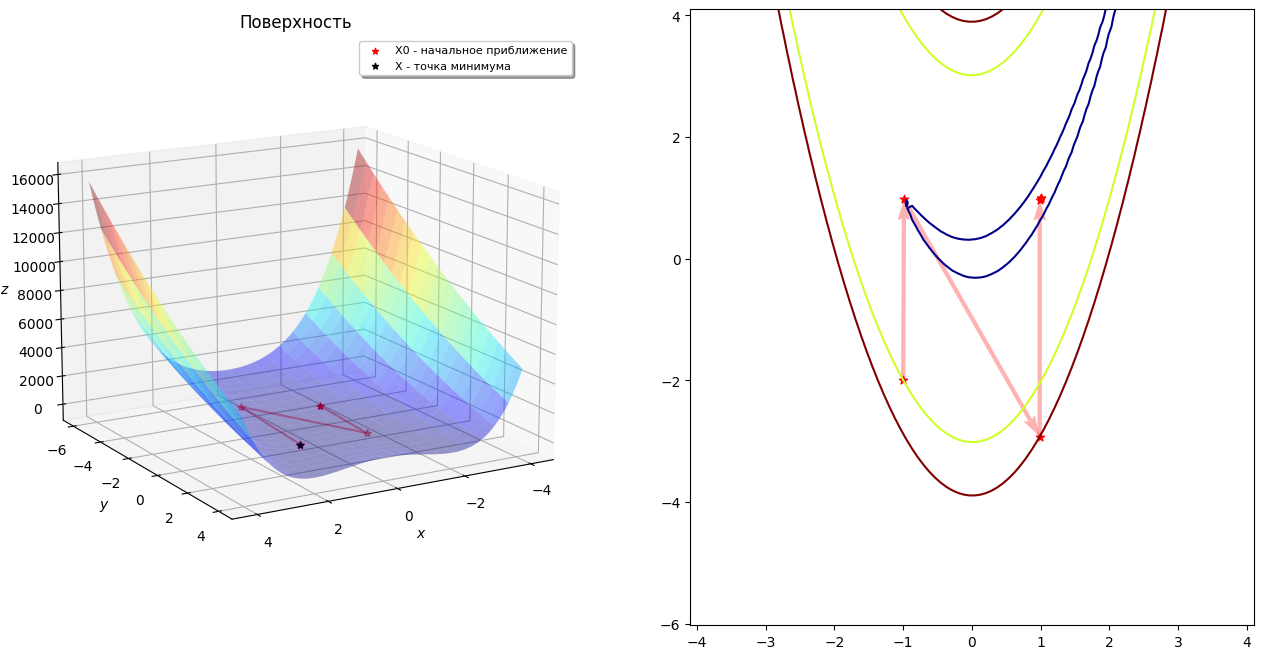

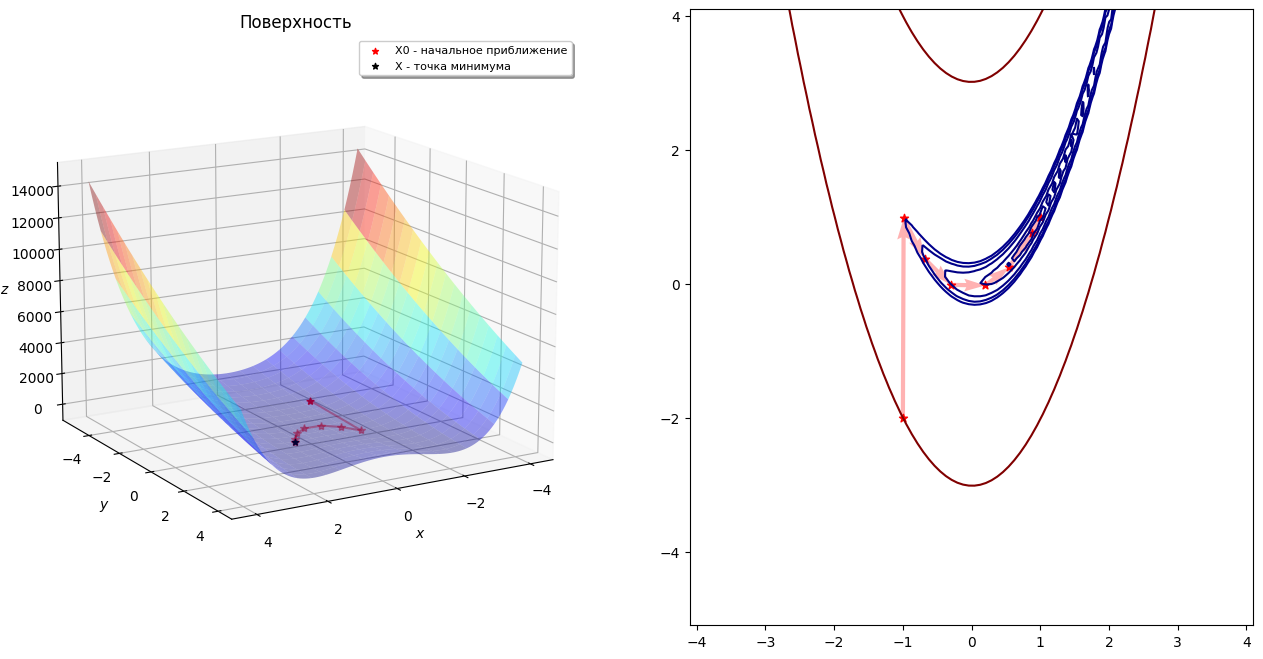

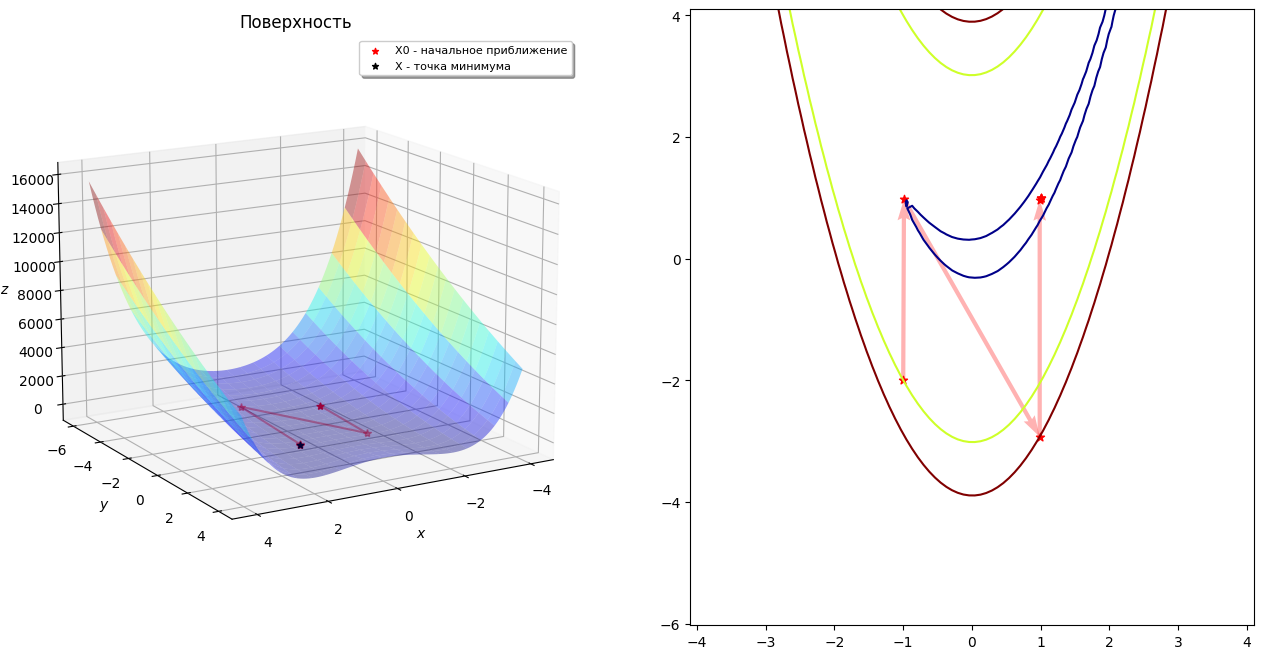

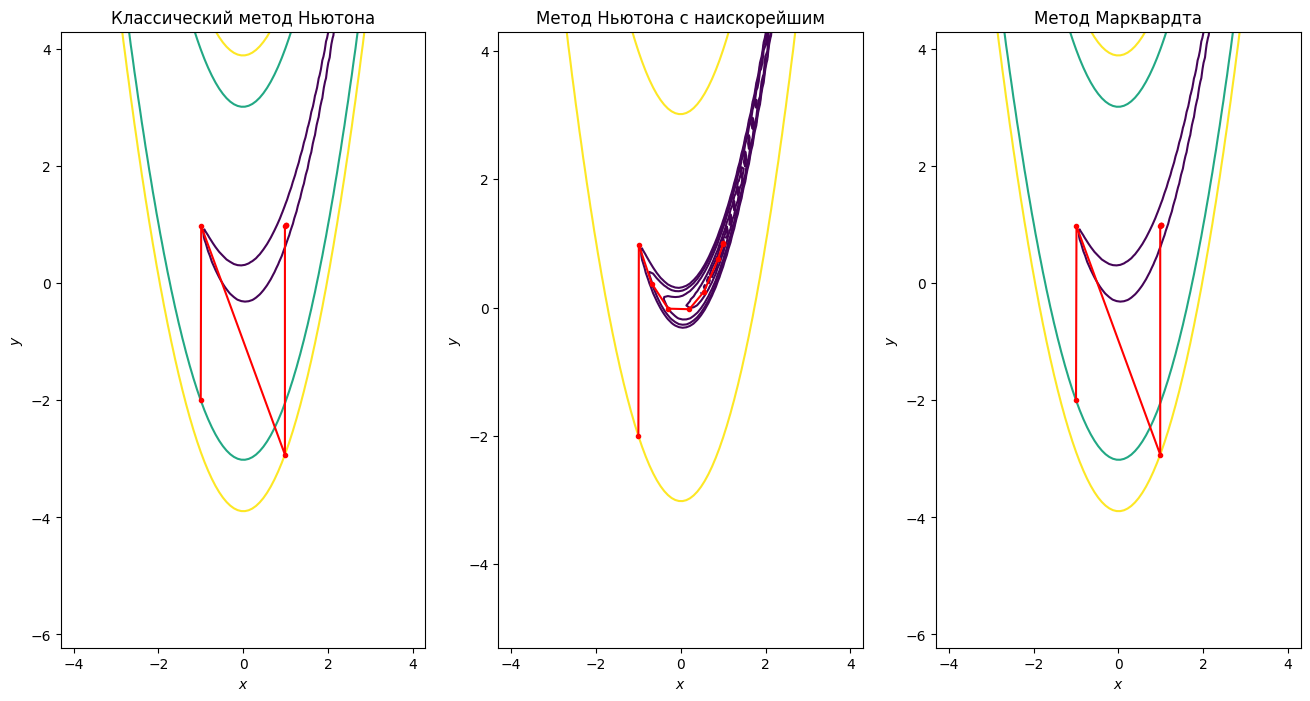

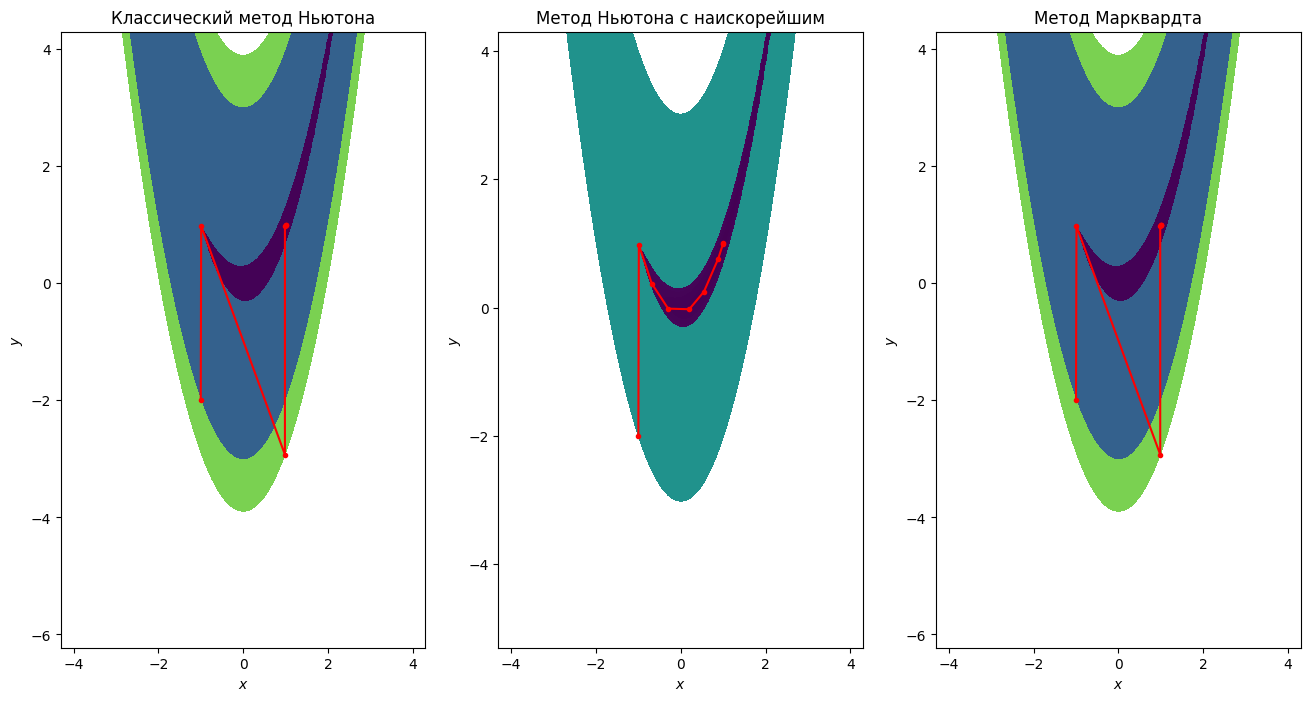

In [2]:
from ast import While
from modulefinder import packagePathMap
from sympy.tensor.array import derive_by_array
from scipy import optimize

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import math


# Параметры методов:
alpha = 30
eps = 0.01
X0 = np.array([-1, -2])

# функция Розенброка


def f(x, y): return alpha * (x**2 - y)**2 + (x - 1)**2


# Вычисление градиента:
x_sym, y_sym = sp.Symbol('x'), sp.Symbol('y')
Grad_f = derive_by_array(f(x_sym, y_sym), [x_sym, y_sym])
Grad_f = sp.lambdify((x_sym, y_sym), Grad_f, 'numpy')

# Вычисление гессиана
Hessian_f = derive_by_array(derive_by_array(
    f(x_sym, y_sym), [x_sym, y_sym]), [x_sym, y_sym])
Hessian_f = sp.lambdify((x_sym, y_sym), Hessian_f, 'numpy')


# Проверка положительной определенности
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


def is_plus(x):
    if (x[0][0] > 0 and np.linalg.det(x) > 0):
        return True
    else:
        return False


# Метод золотого сечения
def golden_ratio(phi, n, b=5, a=0, e=eps):
    tau = (math.sqrt(5) + 1) / 2
    Ak, Bk = a, b
    lk = Bk - Ak
    Xk1 = Ak + ((Bk - Ak) - (Bk - Ak) / tau)
    Xk2 = Ak + (Bk - Ak) / tau
    y1, y2 = phi(Xk1), phi(Xk2)
    n += 2
    while lk >= e/100:
        if y1 >= y2:
            Ak = Xk1
            Xk1 = Xk2
            Xk2 = Ak + Bk - Xk1
            y1 = y2
            y2 = phi(Xk2)
            n += 1
        else:
            Bk = Xk2
            Xk2 = Xk1
            Xk1 = Ak + Bk - Xk2
            y2 = y1
            y1 = phi(Xk1)
            n += 1
        lk = Bk - Ak
    return (Ak + Bk) / 2, n


# Классический метод Ньютона
def newtown():
    def w(X): return -np.array(Grad_f(X[0], X[1]))
    def fun(X): return f(X[0], X[1])
    X = X0
    X_p, Y_p = np.empty(0), np.empty(0)
    X_p = np.append(X_p, X[0])
    Y_p = np.append(Y_p, X[1])
    wk = w(X)
    g = 1
    i = n = h = 0
    while np.linalg.norm(wk) > eps:
        H = Hessian_f(X[0], X[1])
        h += 1
        # проверка положительной определенности
        # eta = 0
        # while is_pos_def(H) == False:
        #     eta += 0.1
        #     H = eta * np.eye(2) + H

        # находим решение СЛАУ рк
        p = np.linalg.solve(H, wk)
        # наша следующая точка
        Xk = X + p
        X = Xk
        X_p = np.append(X_p, X[0])
        Y_p = np.append(Y_p, X[1])
        wk = w(Xk)
        g += 1
        H = Hessian_f(X[0], X[1])
        i += 1

    return X, X_p, Y_p, i, n, g, h


# Модификация метода Ньютона с наискорейшим
def newton_with_fastest():
    def w(X): return -np.array(Grad_f(X[0], X[1]))
    def fun(X): return f(X[0], X[1])

    X_p, Y_p = np.empty(0), np.empty(0)
    X = X0
    X_p = np.append(X_p, X[0])
    Y_p = np.append(Y_p, X[1])
    i = n = h = 0
    g = 1
    while np.linalg.norm(w(X)) > eps:

        H = Hessian_f(X[0], X[1])
        h += 1
        # # проверка положительной определенности
        # eta = 0
        # while is_pos_def(H) == False:
        #     eta += 0.1
        #     H = eta * np.eye(2) + H

        # находим решение СЛАУ р
        p = np.linalg.solve(H, w(X))

        # минимизируем функцию
        def phi(kappa): return fun(X + kappa * p)
        kappa, arg, k = optimize.golden(phi, full_output=True)
        #kappa, k = golden_ratio(phi, n)
        n += k
        X = X + kappa * p
        X_p = np.append(X_p, X[0])
        Y_p = np.append(Y_p, X[1])
        i += 1
        g += 1
    return X, X_p, Y_p, i, n, g, h


# Модификация метода Ньютона - метод Марквардта
def newton_markvardt():
    def w(X): return -np.array(Grad_f(X[0], X[1]))
    def fun(X): return f(X[0], X[1])
    def h(X): return np.array(np.array(Hessian_f(X[0], X[1])))

    a0 = 1000
    b = 0.5
    X = X0
    X_p, Y_p = np.empty(0), np.empty(0)
    X_p = np.append(X_p, X[0])
    Y_p = np.append(Y_p, X[1])
    n = 1
    i = h = g = 0
    while 1:
        wk = w(X)
        g += 1
        a = a0
        H = Hessian_f(X[0], X[1])
        h += 1
        if is_pos_def(H) == False:
            while 2:

                # вычисляем направление
                s = np.linalg.solve(H + a * np.eye(2), wk)

                # находим точку
                Xk = X + s
                n += 1
                if fun(X) >= fun(Xk):
                    a0 *= b
                    break

                a = a / b
                # X = Xk
                # wk = w(X)
                # g += 1
        else:
            s = np.linalg.solve(H, wk)

        Xk = X + s
        i += 1
        X = Xk
        X_p = np.append(X_p, X[0])
        Y_p = np.append(Y_p, X[1])
        if np.linalg.norm(wk) < eps:
            break
    return X, X_p, Y_p, i, n, g, h


# Не очень картинки
def DrawSurfContourAndWk(X2, X3, X4, X2_p, Y2_p, X3_p, Y3_p, X4_p, Y4_p):
    fig = plt.figure(figsize=(16, 8))
    # fig.canvas.manager.full_screen_toggle()

    axes1 = fig.add_subplot(1, 3, 1)
    axes2 = fig.add_subplot(1, 3, 2)
    axes3 = fig.add_subplot(1, 3, 3)

    fig.canvas.manager.set_window_title('Методы сопряженного градиента')
    
    delta = max(abs(X2[0] - X0[0]), abs(X2[1] - X0[1])) + 0.3
    X = np.linspace(np.min(X2_p) - delta, np.max(X2_p) + delta,  100)
    Y = np.linspace(np.min(Y2_p) - delta, np.max(Y2_p) + delta, 100)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)
    
    axes1.contourf(X, Y, Z, levels=Val(X2_p, Y2_p))
    axes1.plot(X2_p, Y2_p, marker='o', markersize=3, color='red')
    axes1.set_xlabel('$x$')
    axes1.set_ylabel('$y$')
    axes1.set_title('Классический метод Ньютона')

    delta = max(abs(X3[0] - X0[0]), abs(X3[1] - X0[1])) + 0.3
    X = np.linspace(np.min(X3_p) - delta, np.max(X3_p) + delta,  100)
    Y = np.linspace(np.min(Y3_p) - delta, np.max(Y3_p) + delta, 100)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)

    axes2.contourf(X, Y, Z, levels=Val(X3_p, Y3_p))
    axes2.plot(X3_p, Y3_p, marker='o', markersize=3, color='red')
    axes2.set_xlabel('$x$')
    axes2.set_ylabel('$y$')
    axes2.set_title('Метод Ньютона с наискорейшим')

    delta = max(abs(X4[0] - X0[0]), abs(X4[1] - X0[1])) + 0.3
    X = np.linspace(np.min(X4_p) - delta, np.max(X4_p) + delta,  100)
    Y = np.linspace(np.min(Y4_p) - delta, np.max(Y4_p) + delta, 100)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)

    axes3.contourf(X, Y, Z, levels=Val(X4_p, Y4_p))
    axes3.plot(X4_p, Y4_p, marker='o', markersize=3, color='red')
    axes3.set_xlabel('$x$')
    axes3.set_ylabel('$y$')
    axes3.set_title('Метод Марквардта')


# 3D и линии уровня двух графиков
def DrawSurfContour(X2, X3, X4, X2_p, Y2_p, X3_p, Y3_p, X4_p, Y4_p):
    fig = plt.figure(figsize=(16, 8))
    # fig.canvas.manager.full_screen_toggle()

    axes1 = fig.add_subplot(1, 3, 1)
    axes2 = fig.add_subplot(1, 3, 2)
    axes3 = fig.add_subplot(1, 3, 3)

    fig.canvas.manager.set_window_title('Методы сопряженного градиента')

    # delta = max(abs(X2[0] - X0[0]), abs(X2[1] - X0[1])) + 0.3
    # X, Y = np.meshgrid(np.linspace(X2[0] - delta, X2[0] + delta, 50),
    #                    np.linspace(X2[1] - delta, X2[1] + delta, 50))
    # # X, Y = np.meshgrid(X_p1, Y_p1)
    # Z = f(X, Y)

    delta = max(abs(X2[0] - X0[0]), abs(X2[1] - X0[1])) + 0.3
    X = np.linspace(np.min(X2_p) - delta, np.max(X2_p) + delta,  100)
    Y = np.linspace(np.min(Y2_p) - delta, np.max(Y2_p) + delta, 100)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)

    axes1.contour(X, Y, Z, levels=Val(X2_p, Y2_p))
    axes1.plot(X2_p, Y2_p, marker='o', markersize=3, color='red')
    axes1.set_xlabel('$x$')
    axes1.set_ylabel('$y$')
    axes1.set_title('Классический метод Ньютона')

    delta = max(abs(X3[0] - X0[0]), abs(X3[1] - X0[1])) + 0.3
    X = np.linspace(np.min(X3_p) - delta, np.max(X3_p) + delta,  100)
    Y = np.linspace(np.min(Y3_p) - delta, np.max(Y3_p) + delta, 100)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)

    axes2.contour(X, Y, Z, levels=Val(X3_p, Y3_p))
    axes2.plot(X3_p, Y3_p, marker='o', markersize=3, color='red')
    axes2.set_xlabel('$x$')
    axes2.set_ylabel('$y$')
    axes2.set_title('Метод Ньютона с наискорейшим')

    delta = max(abs(X4[0] - X0[0]), abs(X4[1] - X0[1])) + 0.3
    X = np.linspace(np.min(X4_p) - delta, np.max(X4_p) + delta,  100)
    Y = np.linspace(np.min(Y4_p) - delta, np.max(Y4_p) + delta, 100)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)

    axes3.contour(X, Y, Z, levels=Val(X4_p, Y4_p))
    axes3.plot(X4_p, Y4_p, marker='o', markersize=3, color='red')
    axes3.set_xlabel('$x$')
    axes3.set_ylabel('$y$')
    axes3.set_title('Метод Марквардта')


# 3D и линии уровня одного графика
def Draw(X_, X_p, Y_p):

    delta = max(abs(X_[0] - X0[0]), abs(X_[1] - X0[1])) + 0.3
    X, Y = np.meshgrid(np.linspace(X_[0] - delta, X_[0] + delta,  100),
                       np.linspace(X_[1] - delta, X_[1] + delta, 100))
    Z = f(X, Y)

    # Angles needed for quiver plot
    anglesx = X_p[1:] - X_p[:-1]
    anglesy = Y_p[1:] - Y_p[:-1]

    fig = plt.figure(figsize=(16, 8))
    fig.canvas.manager.set_window_title('Классический метод Ньютона')

    # Surface plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(X, Y, Z, rstride=5, cstride=5,
                    cmap='jet', alpha=.4, edgecolor='none')
    ax.plot(X_p, Y_p, f(X_p, Y_p), color='r', marker='*', alpha=.4)

    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor = 'none')
    ax.scatter(X0[0], X0[1], f(X0[0], X0[1]), s=20, marker='*',
               c='red', label='X0 - начальное приближение')
    ax.scatter(X_[0], X_[1], f(X_[0], X_[1]), s=20, marker='*',
               c='black', label='X - точка минимума')
    ax.legend(shadow=True, fontsize=8)
    ax.view_init(15, 60)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.set_title('Поверхность данной функции')

    # Contour plot
    ax = fig.add_subplot(1, 2, 2)
    #ax.contour(X, Y, Z, levels = Val(X_p, Y_p), cmap = 'jet')
    ax.contour(X, Y, Z, cmap='jet')

    # Plotting the iterations and intermediate values
    ax.scatter(X_p, Y_p, color='r', marker='*')
    ax.quiver(X_p[:-1], Y_p[:-1], anglesx, anglesy,
              scale_units='xy', angles='xy', scale=1, color='r', alpha=.3)


def Draw3(X_, X_p, Y_p):

    delta = max(abs(X_[0] - X0[0]), abs(X_[1] - X0[1])) + 0.1
    X = np.linspace(np.min(X_p) - delta, np.max(X_p) + delta,  100)
    Y = np.linspace(np.min(Y_p) - delta, np.max(Y_p) + delta, 100)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)

    # Angles needed for quiver plot
    anglesx = X_p[1:] - X_p[:-1]
    anglesy = Y_p[1:] - Y_p[:-1]

    fig = plt.figure(figsize=(16, 8))
    fig.canvas.manager.set_window_title('Методы Ньютона')

    # Surface plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(X, Y, Z, rstride=5, cstride=5,
                    cmap='jet', alpha=.4, edgecolor='none')
    ax.plot(X_p, Y_p, f(X_p, Y_p), color='r', marker='*', alpha=.4)

    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor = 'none')
    ax.scatter(X0[0], X0[1], f(X0[0], X0[1]), s=20, marker='*',
               c='red', label='X0 - начальное приближение')
    ax.scatter(X_[0], X_[1], f(X_[0], X_[1]), s=20, marker='*',
               c='black', label='X - точка минимума')
    ax.legend(shadow=True, fontsize=8)
    ax.view_init(15, 60)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.set_title('Поверхность')

    delta = max(abs(X_[0] - X0[0]), abs(X_[1] - X0[1])) + 0.1
    X = np.linspace(np.min(X_p) - delta, np.max(X_p) + delta,  100)
    Y = np.linspace(np.min(Y_p) - delta, np.max(Y_p) + delta, 100)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)
    # Contour plot
    ax = fig.add_subplot(1, 2, 2)
    ax.contour(X, Y, Z, levels=Val(X_p, Y_p), cmap='jet')
    #ax.contour(X, Y, Z, cmap = 'jet')

    # Plotting the iterations and intermediate values
    ax.scatter(X_p, Y_p, color='r', marker='*')
    ax.quiver(X_p[:-1], Y_p[:-1], anglesx, anglesy,
              scale_units='xy', angles='xy', scale=1, color='r', alpha=.3)


# Таблица точек и значений
def DrawPoints(X_p, Y_p):
    for x in range(len(X_p)):
        print('X = [', '%.6f' % X_p[x], ' ', '%.6f' %
              Y_p[x], ']', '\tf = ', '%.6f' % f(X_p[x], Y_p[x]))


# Значения функции
def Val(X_p, Y_p):
    Value = []
    for i in range(len(X_p)):
        Value.insert(0, f(X_p[i], Y_p[i]))

    return np.sort(Value)


print(" " * 20, ' Методы второго порядка')
print('Дано:')
print('Целевая функция:        f(x, y) = ', f(x_sym, y_sym))
print('Начальное приближение:  X = ', X0)
print('Точность вычисления:    Eps = ', eps)

# X1, X1_p, Y1_p, i1, n1, g1, h1 = newtown()
# print('Точка минимума: ', X1)
# print('Минимум: ',f(X1[0],X1[1]))
# print('Количество итераций: ', i1)
# print('Количество вычислений: ', n1)
# print('Количество градиентов: ', g1)
# print('Количество матриц Гессе: ', h1)
# DrawPoints(X1_p, Y1_p)
# Draw(X1, X1_p, Y1_p)


# X2, X2_p, Y2_p, i2, n2, g2, h2 = newton_with_fastest()
# print('Точка минимума: ', X2)
# print('Минимум: ',f(X2[0],X2[1]))
# print('Количество итераций: ', i2)
# print('Количество вычислений: ', n2)
# print('Количество градиентов: ', g2)
# print('Количество матриц Гессе: ', h2)
# #DrawPoints(X2_p, Y2_p)
# Draw3(X2, X2_p, Y2_p)


# X3, X3_p, Y3_p, i3, n3, g3, h3 = newton_markvardt()
# print('Точка минимума: ', X3)
# print('Минимум: ',f(X3[0],X3[1]))
# print('Количество итераций: ', i3)
# print('Количество вычислений: ', n3)
# print('Количество градиентов: ', g3)
# print('Количество матриц Гессе: ', h3)
# #DrawPoints(X3_p, Y3_p)
# Draw3(X3, X3_p, Y3_p)

X1, X1_p, Y1_p, i1, n1, g1, h1 = newtown()
X2, X2_p, Y2_p, i2, n2, g2, h2 = newton_with_fastest()
X3, X3_p, Y3_p, i3, n3, g3, h3 = newton_markvardt()
print()
print('**********************************************************************************************************************************************************************')
print('Методы\t', '       Классический метод Ньютона\t',
      '     Метод Ньютона с наискорейшим\t', '   Метод Марквардта')
print('Xmin  \t\t\t',  X1, '\t\t', X2, '\t', X3)
print('f(Xmin)\t\t', f(X1[0], X1[1]), '\t\t\t\t', f(
    X2[0], X2[1]), '\t\t\t', f(X3[0], X3[1]))
print('i\t\t\t', i1, '\t\t\t\t\t', i2, '\t\t\t\t\t', i3)
print('n\t\t\t', n1, '\t\t\t\t\t', n2, '\t\t\t\t\t', n3)
# print('g\t\t\t', g1, '\t\t\t\t\t', g2, '\t\t\t\t\t', g3)
# print('h\t\t\t', h1, '\t\t\t\t\t', h2, '\t\t\t\t\t', h3)
print('**********************************************************************************************************************************************************************')
Draw3(X1, X1_p, Y1_p)
Draw3(X2, X2_p, Y2_p)
Draw3(X3, X3_p, Y3_p)
DrawSurfContour(X1, X2, X3, X1_p, Y1_p, X2_p, Y2_p, X3_p, Y3_p)
DrawSurfContourAndWk(X1, X2, X3, X1_p, Y1_p, X2_p, Y2_p, X3_p, Y3_p)


plt.show()
